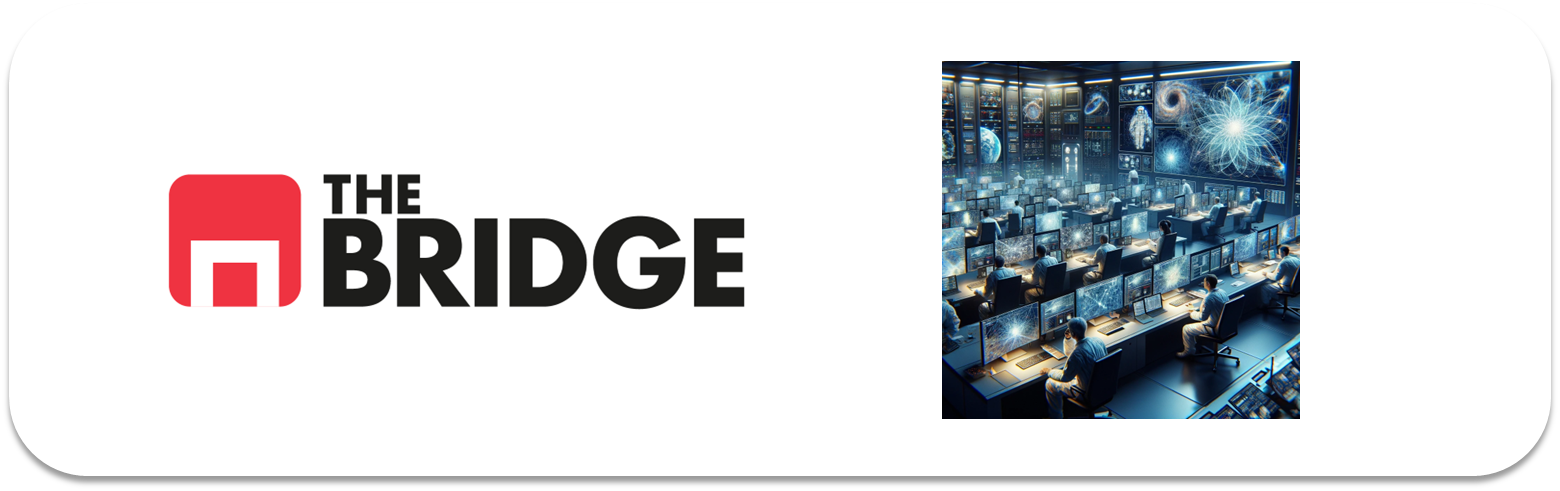

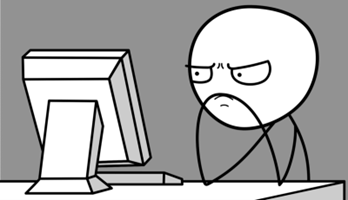

Para ejercitarte y afianzar lo aprendido sobre **Redes Convolucionales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras
import cv2

## El problema de "Negocio"
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en https://www.kaggle.com/datasets/puneet6060/intel-image-classification?select=seg_test como `seg_train.zip` y `seg_test.zip` (o bien en el botón de download).  

NOTA: Son archivos bastante grandes (386MB en total). Por supuesto, no es necesario que tengas que mantenerlos en tu ordenador una vez realizado el ejercicio, bórralos si es el caso.




### Ejercicio 1

Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones). Para ello:

1. Descarga las imagenes del repositorio de Kaggle en el directorio que vayas a emplear para el ejercicio.
2. Descomprime los datos (son ficheros de imágenes) de forma que tengas dos subdirectorios seg_train y seg_test en el que estén ya colgando directamente los directorios de cada clase de paisajes. Si descargaste seg_pred, puedes eliminarlo.
3. Crea unas variables como las siguientes (ajustándolas a tu caso/rutas particulares):

```python
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"
```
4. Utiliza la siguiente función para crear los X_train, y_train y X_test e y_test:

```python
def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)
```


*Pues copiamos lo que nos dicen y lo aplicamos a los dos directorios para tener las X y las y*

In [14]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"



In [26]:
def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folders in os.listdir(directorio):
        if os.path.isdir('/'.join([directorio, folders])):
            for file in os.listdir('/'.join([directorio, folders])):
                #print(f"file:{file}")
                image = imread('/'.join([directorio, folders, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32
                X.append(image)
                y.append(folders)

    return np.array(X),np.array(y)

In [27]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH) # Nota: podríamos dejar la creación de X_test para el final antes de usarlo y así ahorra memoria mientras no tengamos que emplearlo

### Ejercicio 2

Haz la visualización del dataset: comprueba cuantos datos tienes, que forma, investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.


In [28]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 32, 32, 3)
Y train shape:  (14034,)


*14034 imagenes de 32x32 con 3 canales para los colores en el train*

In [29]:
print('X train shape: ', X_test.shape)
print('Y train shape: ', y_test.shape)

X train shape:  (3000, 32, 32, 3)
Y train shape:  (3000,)


*3000 imagenes en el test*

*Adaptemos nuestra clásica función de pintado de imágenes*

In [30]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

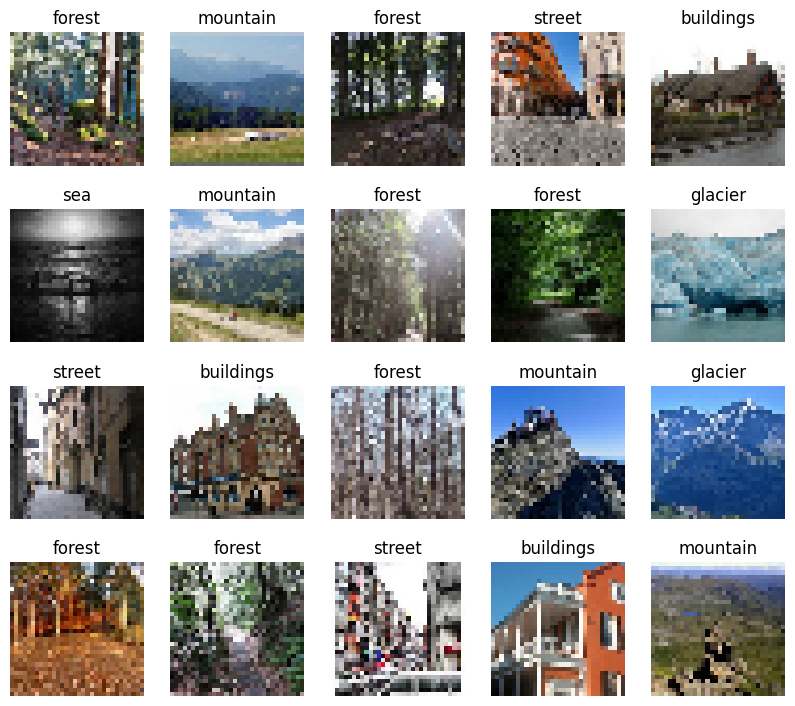

In [31]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

*A nuestra vista, la reduccion de la resolución afecta, si quieres puedes cambiar el tamaño de resolución y probar, pero ya sabes que será a costa de tiempo de computación*

### Ejercicio 3

Ahora haz un pequeño miniEda y normaliza las features



*Veamos la distribución de cada tipo de paisaje*

In [32]:
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

*Tenemos que construir un clasificador multiclase con 6 clases posibles que están más o menos balanceadas aunque hay una ligera superioridad de muestra de paisajes de montaña respecto al de edificios*

*Y ahora un clásico de la normalización de imágenes:*

In [33]:
X_train = X_train/255
X_test = X_test/255

*Recuerda que normalizar es bueno aunque estén en la misma escala por un lado porque las funciones de activación sulen trabajar mejor en rangos entre -1,0 y 1 (sobre todo las tanh, sigmoide, etc) y por otro porque valores altos de entrada sientan peor a la hora de hacer el gradiente descendente con backpropagation*

### Ejercicio 4

Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada. Como guía, copia o parte de la arquitectura del workout (un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer)


In [34]:
# Primero definimos las capas de la red, en este caso partimos de 30 filtros de 3x3, seguido de una capa de pooling de 2x2,
# El input shape es el tamaño de las imágenes de entrada, en nuestro caso 32x32x3. 
# El tamaño del kernel es pequeño pero suele ser de este tipo y más con resoluciones tan bajas, el número de filtros está escogido de aquella manera,
# juega con el número de filtros.

capas = [keras.layers.Conv2D(filters = 30, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape), 
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 15, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación 
         keras.layers.Dense(units = 150, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 6 neuronas, una por cada clase
         keras.layers.Dense(6, activation = 'softmax')]

# Creamos el modelo
model = keras.Sequential(capas)

### Ejercicio 5

Escoge el resto de hiperparámetros (optimizador, learning_rate, función de pérdida, métrica,...) y compila el modelo. Muestra un resumen del mismo

*Para escoger el optimizador me fijo en el tamaño del dataset*

In [35]:
X_train.size

43112448

*Dado el tamaño podemos usar un adam, cuyos hiperparámetros por defecto suelen funcionar bastante bien*

*Como el target es unidimensional usaré sparse_categorical y como métrica dado el balanceo la accuracy.*


In [36]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

*Ahora el resumen del modelo*


In [37]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 30)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 15)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 150)               1

### Ejercicio 6

Entrena el modelo reservando un 20% de los datos del entrenamiento para validar y con los callbacks que creas necesarios. NOTA: Ojo, tendrás que preparar un poco los X,y antes.



*Primero tendremos que convertir nuestro target a un ordinal :-)*

In [38]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [39]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

*Además los datos están ordenados, por lo que debemos hacer un shuffle*

In [40]:
# Revolvemos los datos para que el modelo no aprenda en orden de las imágenes
X_train, y_train_num = shuffle(X_train, y_train_num)

In [41]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 32, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)]) # Queremos recuperar los pesos de la mejor de las epocas durante el periodo de patience

Epoch 1/100


351/351 [==============================] - 3s 6ms/step - loss: 1.1202 - accuracy: 0.5610 - val_loss: 0.8780 - val_accuracy: 0.6687
Epoch 2/100
351/351 [==============================] - 2s 6ms/step - loss: 0.8454 - accuracy: 0.6781 - val_loss: 0.8260 - val_accuracy: 0.6929
Epoch 3/100
351/351 [==============================] - 2s 6ms/step - loss: 0.7423 - accuracy: 0.7241 - val_loss: 0.7250 - val_accuracy: 0.7428
Epoch 4/100
351/351 [==============================] - 2s 6ms/step - loss: 0.6730 - accuracy: 0.7529 - val_loss: 0.7262 - val_accuracy: 0.7339
Epoch 5/100
351/351 [==============================] - 2s 6ms/step - loss: 0.6054 - accuracy: 0.7807 - val_loss: 0.6891 - val_accuracy: 0.7656
Epoch 6/100
351/351 [==============================] - 2s 6ms/step - loss: 0.5582 - accuracy: 0.7973 - val_loss: 0.6764 - val_accuracy: 0.7520
Epoch 7/100
351/351 [==============================] - 2s 6ms/step - loss: 0.5055 - accuracy: 0.8136 - val_loss: 0.6802 - val_accuracy: 0.75


### Ejercicio 7

Representa el objeto history y comenta la evolución de tu entrenamiento.



*Observando la evolución de la métrica:*

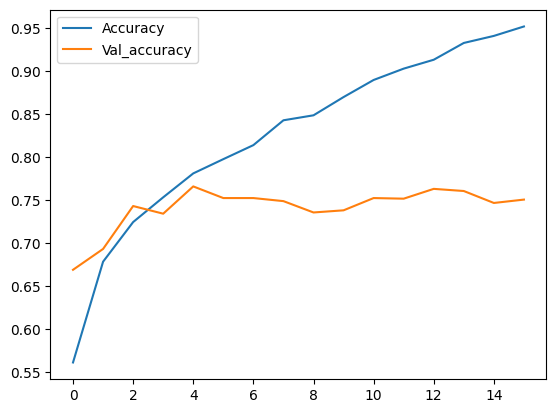

In [42]:
# Representamos el objeto history
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')

plt.legend();

*Observando la evolución de la pérdida:*

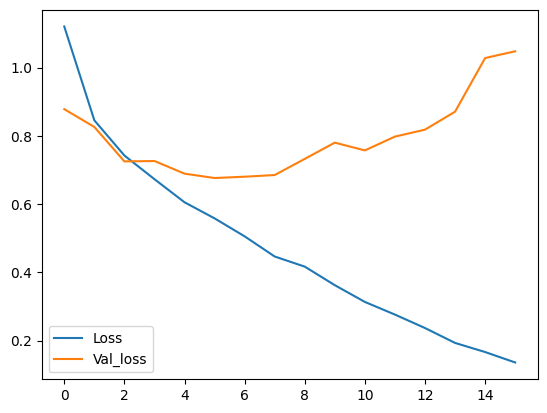

In [43]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();

*En ambas figuras se ve que pasadas las primeras 5 épocas, sólo estamos consiguiendo es hacer overfitting y más superadas las 10 épocas en la que incluso sube el error de validación y el de train sigue bajando*


### Ejercicio 8

Evalua el modelo con los datos de test, además muestra el report de clasificación y la matriz de confusión.



In [44]:
model.evaluate(X_test, y_test_num)

94/94 [==============================] - 0s 2ms/step - loss: 0.6681 - accuracy: 0.7670


[0.6681448817253113, 0.7670000195503235]

*Un 75% de accuracy que se traduce en el siguiente report*

In [45]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 [==============================] - 0s 2ms/step


In [46]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.74      0.64      0.69       437
      forest       0.87      0.93      0.90       474
     glacier       0.78      0.70      0.74       553
    mountain       0.74      0.75      0.74       525
         sea       0.71      0.75      0.73       510
      street       0.76      0.83      0.79       501

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000



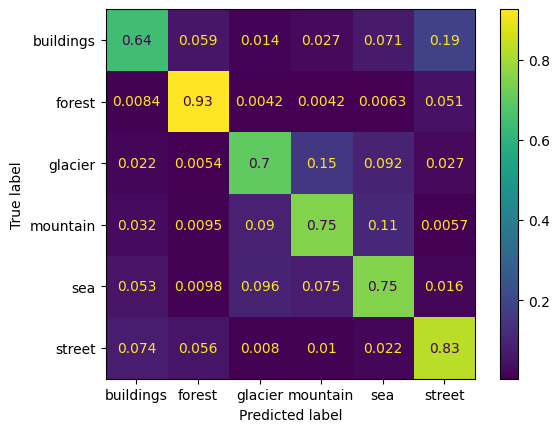

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")

*Hay un rectángulo interesante en el centro de la matriz, los glaciares (los paisajes peor detectados) se confunden principalmente con montañas, aunque estas se reconocen bastante bien. El mar también se confunde cuando lo hace con montañas. Esto hace que la precisión de las montañas baje. El mejor clasificado son los bosques seguido de las calles. Los edificios tampoco se clasifican bien y como era de esperar se confunden con las calles*


### Ejercicio 9 

Representa algunos de los paisajes donde el modelo comete errores y muestra la confianza que tenía en ellos.





In [48]:
confianza = [prediction.max() for prediction in model.predict(X_test)]

94/94 [==============================] - 0s 2ms/step


In [49]:
pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confianza": confianza})

In [50]:
error = pred_df["True"] != pred_df["Predicted"]
errores = pred_df[error].sort_values("Confianza", ascending = False)
errores

,True,Predicted,Confianza
79,buildings,forest,0.999295
347,buildings,street,0.995822
1904,mountain,sea,0.995789
195,buildings,street,0.994617
1525,mountain,sea,0.992926
...,...,...,...
2578,street,sea,0.278867
1717,mountain,glacier,0.275661
1990,sea,street,0.273921
1536,mountain,sea,0.266283


In [51]:
for true_label, predicted_label in errores.iloc[0:10,0:2].values:
    print(true_label, predicted_label)

buildings forest
buildings street
mountain sea
buildings street
mountain sea
glacier mountain
glacier sea
street forest
buildings street
glacier sea


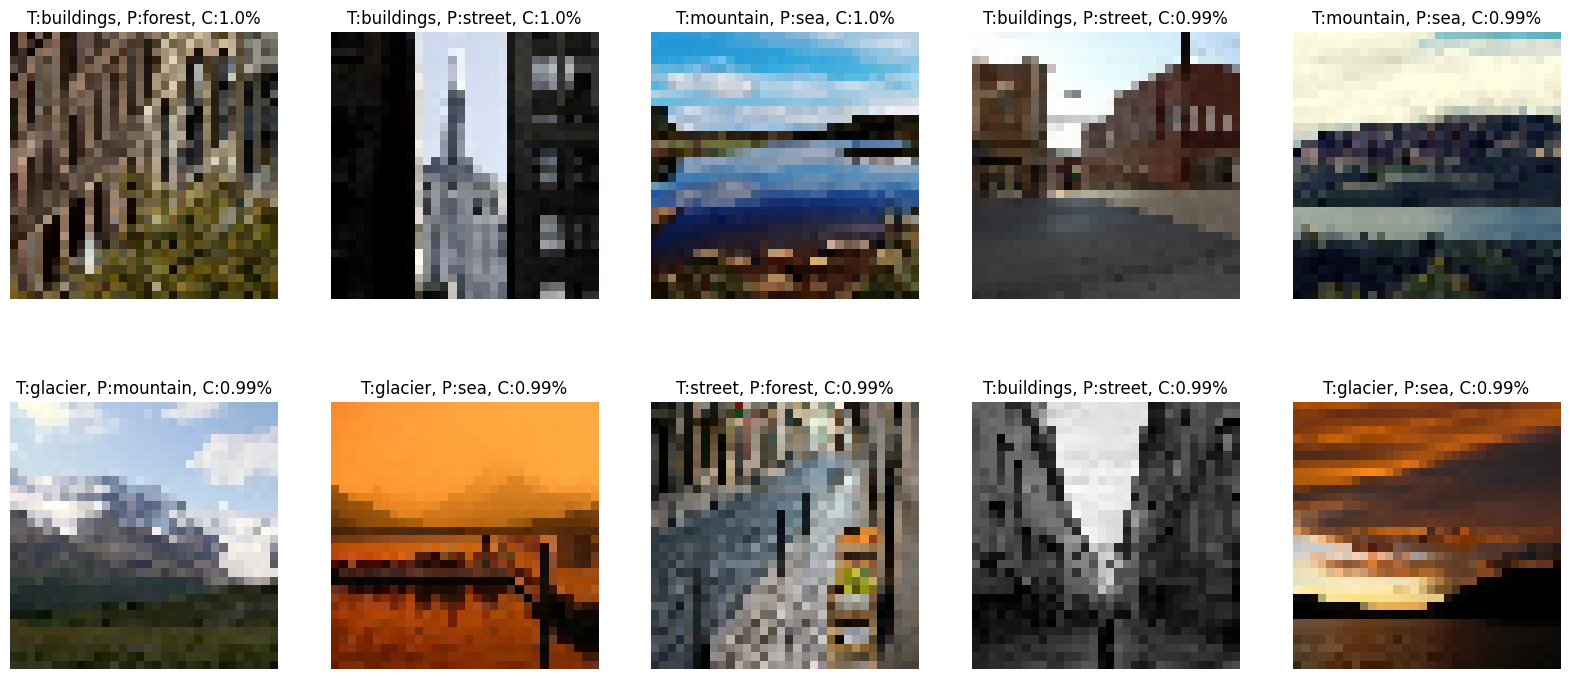

In [52]:
show_images_batch(X_test[errores.iloc[0:10].index],names= [f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1,val2,val3 in errores.iloc[0:10].values], size_scale= 4)

### Ejercicio EXTRA: 

Aumenta la resolución y repite el ejercicio con la misma topología de red

In [53]:
X_train,y_train = read_data(TRAIN_PATH, (64,64))
X_test, y_test = read_data(TEST_PATH, (64,64))

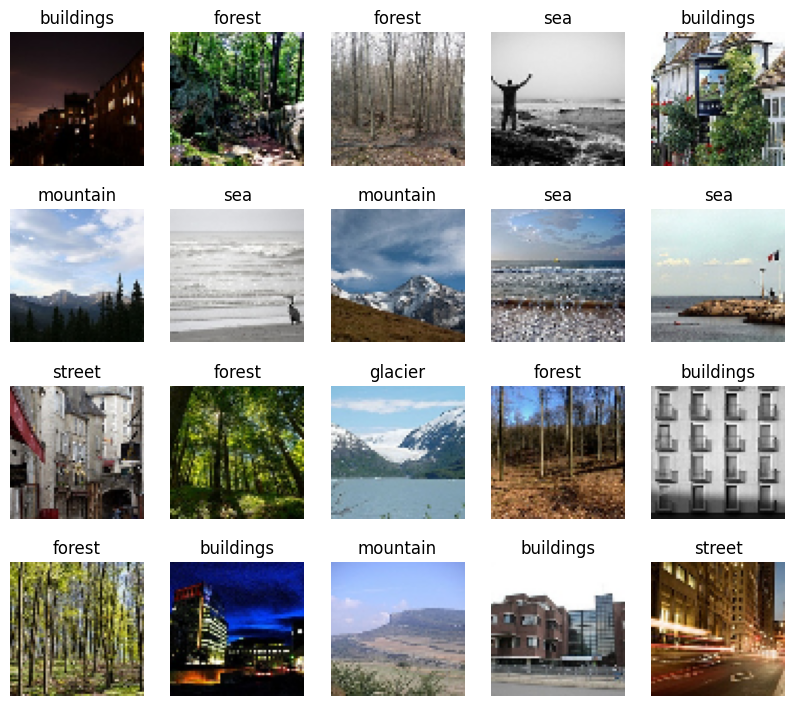

In [54]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [55]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [56]:
X_train, y_train_num = shuffle(X_train, y_train_num)

In [57]:

capas = [keras.layers.Conv2D(filters = 32, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape), 
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 16, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación 
         keras.layers.Dense(units = 300, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 6 neuronas, una por cada clase
         keras.layers.Dense(6, activation = 'softmax')]

# Creamos el modelo
model = keras.Sequential(capas)

In [58]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 300)              

In [60]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 64, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)])

Epoch 1/100
176/176 [==============================] - 14s 68ms/step - loss: 4.9753 - accuracy: 0.4888 - val_loss: 1.0493 - val_accuracy: 0.5921
Epoch 2/100
176/176 [==============================] - 11s 63ms/step - loss: 0.9341 - accuracy: 0.6381 - val_loss: 1.0103 - val_accuracy: 0.6206
Epoch 3/100
176/176 [==============================] - 12s 66ms/step - loss: 0.7373 - accuracy: 0.7184 - val_loss: 1.0167 - val_accuracy: 0.6263
Epoch 4/100
176/176 [==============================] - 12s 67ms/step - loss: 0.5621 - accuracy: 0.7875 - val_loss: 1.0830 - val_accuracy: 0.6388
Epoch 5/100
176/176 [==============================] - 11s 63ms/step - loss: 0.4392 - accuracy: 0.8418 - val_loss: 1.2274 - val_accuracy: 0.6266
Epoch 6/100
176/176 [==============================] - 11s 65ms/step - loss: 0.3577 - accuracy: 0.8698 - val_loss: 1.3021 - val_accuracy: 0.6152
Epoch 7/100
176/176 [==============================] - 10s 58ms/step - loss: 0.2919 - accuracy: 0.8942 - val_loss: 1.5427 - val_ac

In [61]:
model.evaluate(X_test, y_test_num)

94/94 [==============================] - 0s 5ms/step - loss: 1.0305 - accuracy: 0.6120


[1.0304760932922363, 0.6119999885559082]

*A pesar de haber subido la resolución y haber tocado la red tenemos peore prestaciones... Deberíamos jugar con más hiperparámetros o quizás hacer la red mas profunda*

In [62]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 [==============================] - 0s 4ms/step


In [63]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.57      0.63      0.60       437
      forest       0.80      0.86      0.83       474
     glacier       0.50      0.75      0.60       553
    mountain       0.65      0.42      0.51       525
         sea       0.49      0.34      0.40       510
      street       0.71      0.69      0.70       501

    accuracy                           0.61      3000
   macro avg       0.62      0.61      0.61      3000
weighted avg       0.62      0.61      0.60      3000



In [64]:
confianza = [prediction.max() for prediction in model.predict(X_test)]
pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confianza": confianza})

94/94 [==============================] - 0s 4ms/step


In [65]:
error = pred_df["True"] != pred_df["Predicted"]
errores = pred_df[error].sort_values("Confianza", ascending = False)
errores

,True,Predicted,Confianza
86,buildings,street,0.998949
2320,sea,buildings,0.998789
2312,sea,glacier,0.997654
381,buildings,forest,0.997396
333,buildings,forest,0.997245
...,...,...,...
1620,mountain,sea,0.244391
2261,sea,buildings,0.243613
1878,mountain,buildings,0.238564
1980,mountain,glacier,0.223932


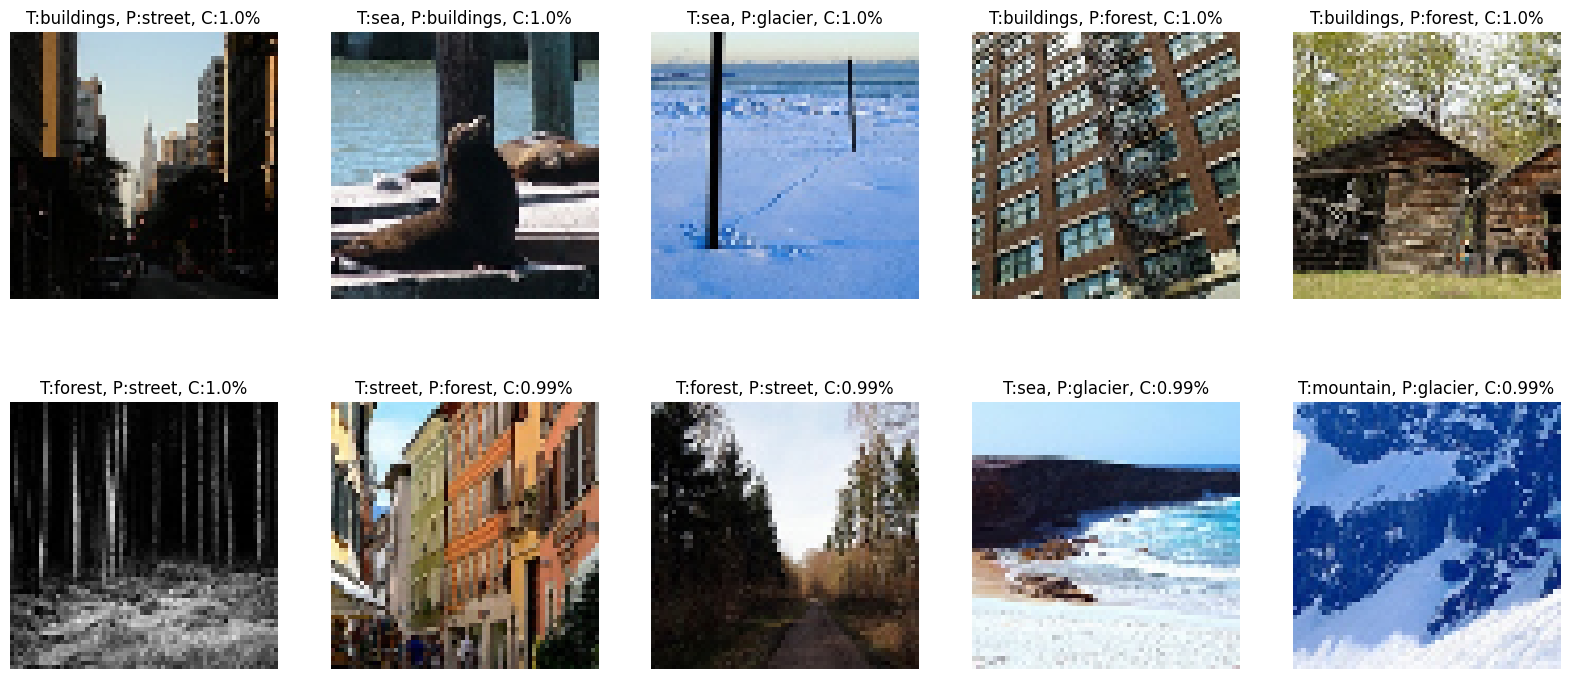

In [66]:
show_images_batch(X_test[errores.iloc[0:10].index],names= [f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1,val2,val3 in errores.iloc[0:10].values], size_scale= 4)

*A veces piensa uno si no estará mal etiquetado :-)*